
# Grid

The grid method provides a convenient way to plot multiple pitches in the same figure.
Unfortunately, it is often hard to control the space between pitches through
Matplotlib's plt.subplots (via the Pitch's draw method).
You have to use trial and error to get a figure looking right.

The grid method makes your life easier; you can fix the space between pitches.
It then automatically calculates the pitch placement and the correct figure width.
I also added the option of including a title_ax and endnote_ax, which align to the pitch sides.

This example takes you through the basics of how the grid method works and then
shows a more complicated example copied
from [Brad (@DymondFormation)](https://twitter.com/DymondFormation) and using
the [highlight_text package](https://github.com/znstrider/highlight_text)
by [@danzn1](https://twitter.com/danzn1).


In [1]:
from urllib.request import urlopen
import warnings

import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from highlight_text import ax_text

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

## Single Pitch
You can also use grid to plot a single pitch with an endnote and title axis.
The defaults setup a pitch with a 2.5%
(of the figure height/ width) border around the sides.



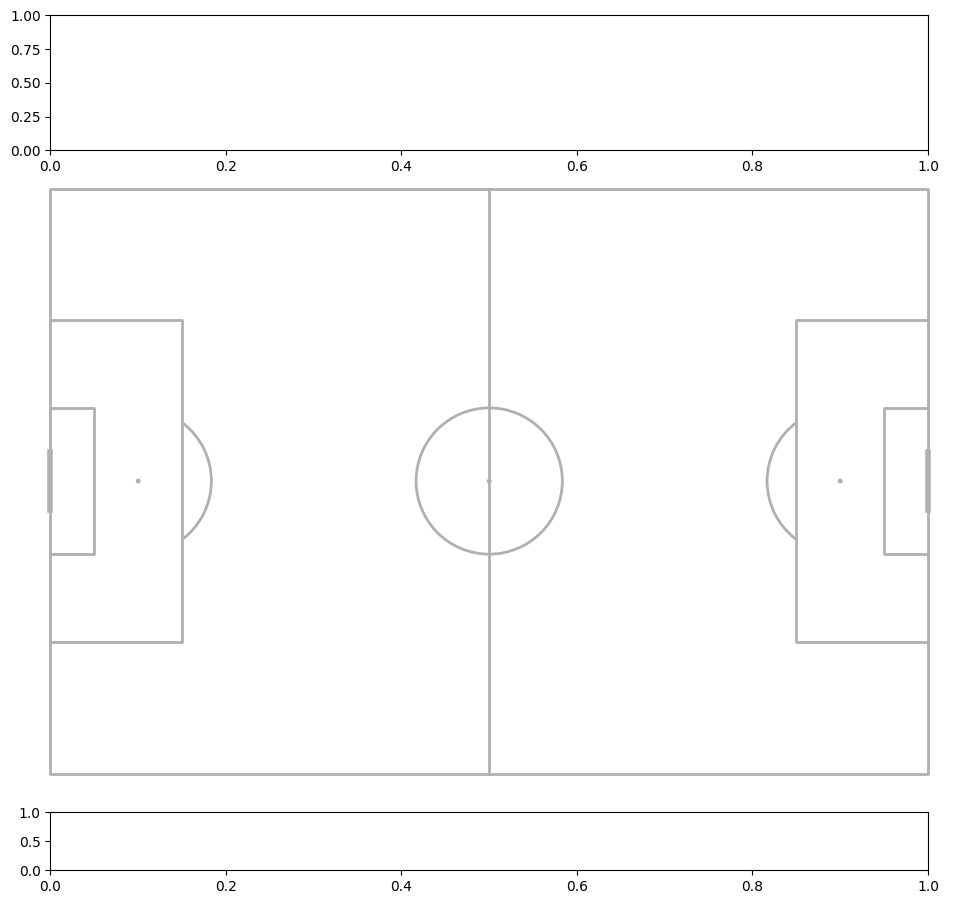

In [2]:
pitch = Pitch()
fig, axs = pitch.grid()

## Multiple Pitches side by side
Next up let's plot 3 pitches side-by-side.



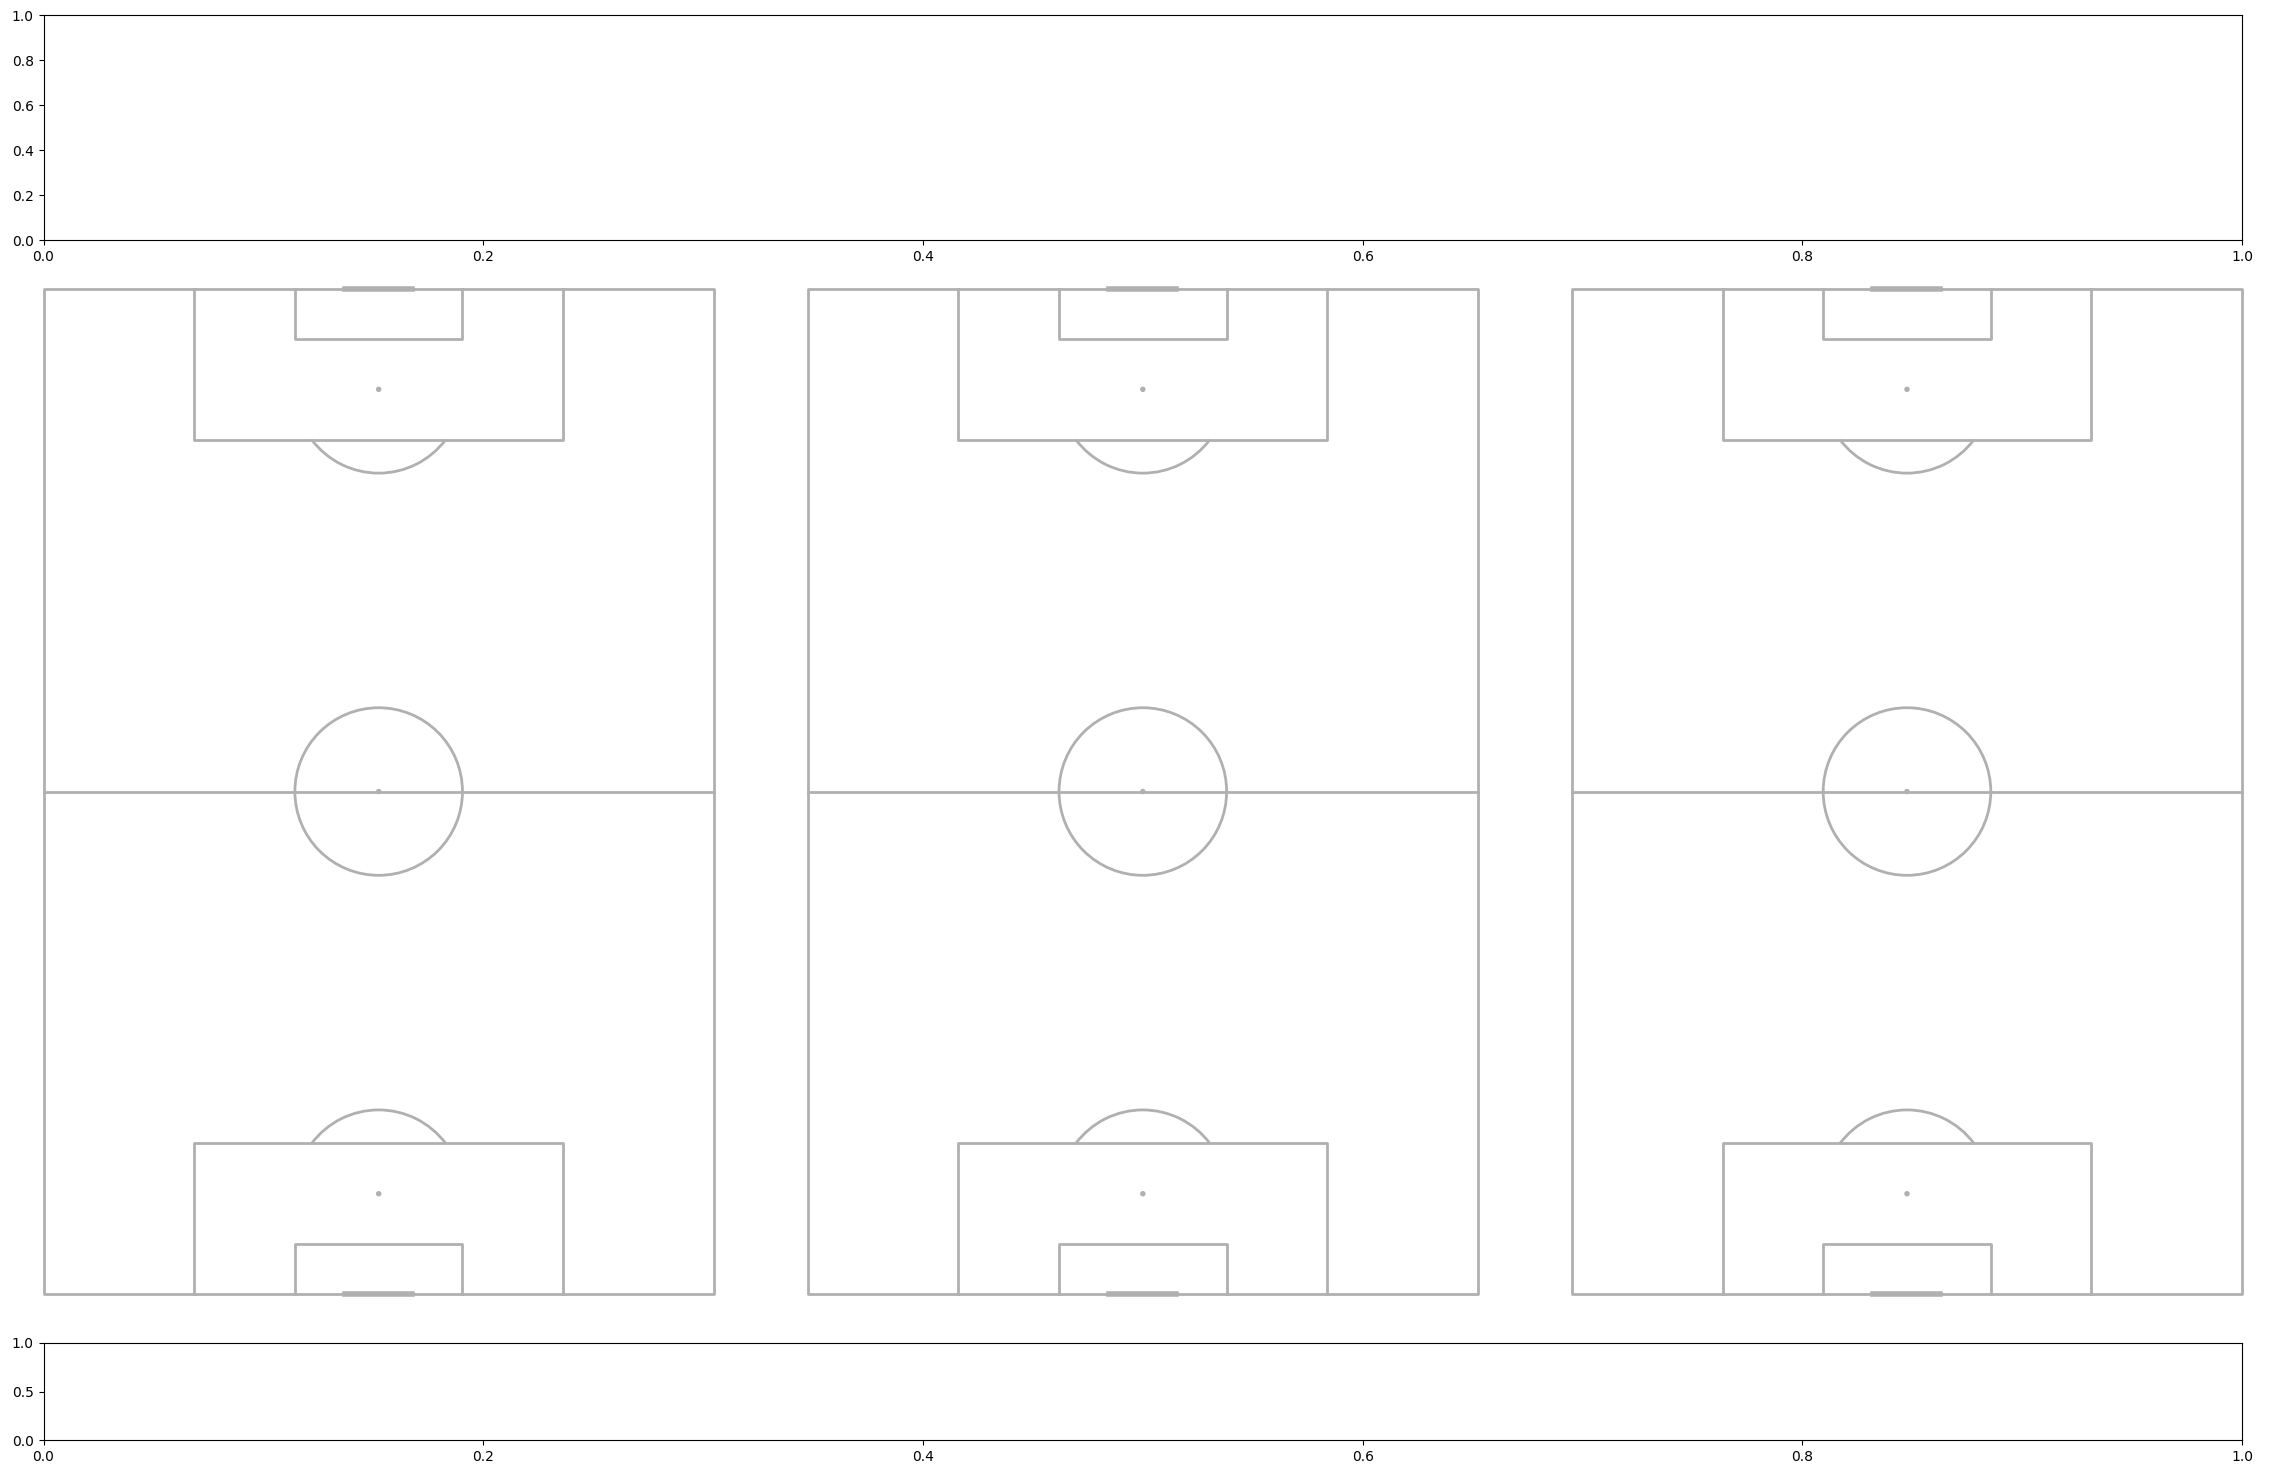

In [3]:
pitch = VerticalPitch()
fig, axs = pitch.grid(figheight=15, ncols=3)

## Grid of Pitches
Here's how to plot a grid of pitches



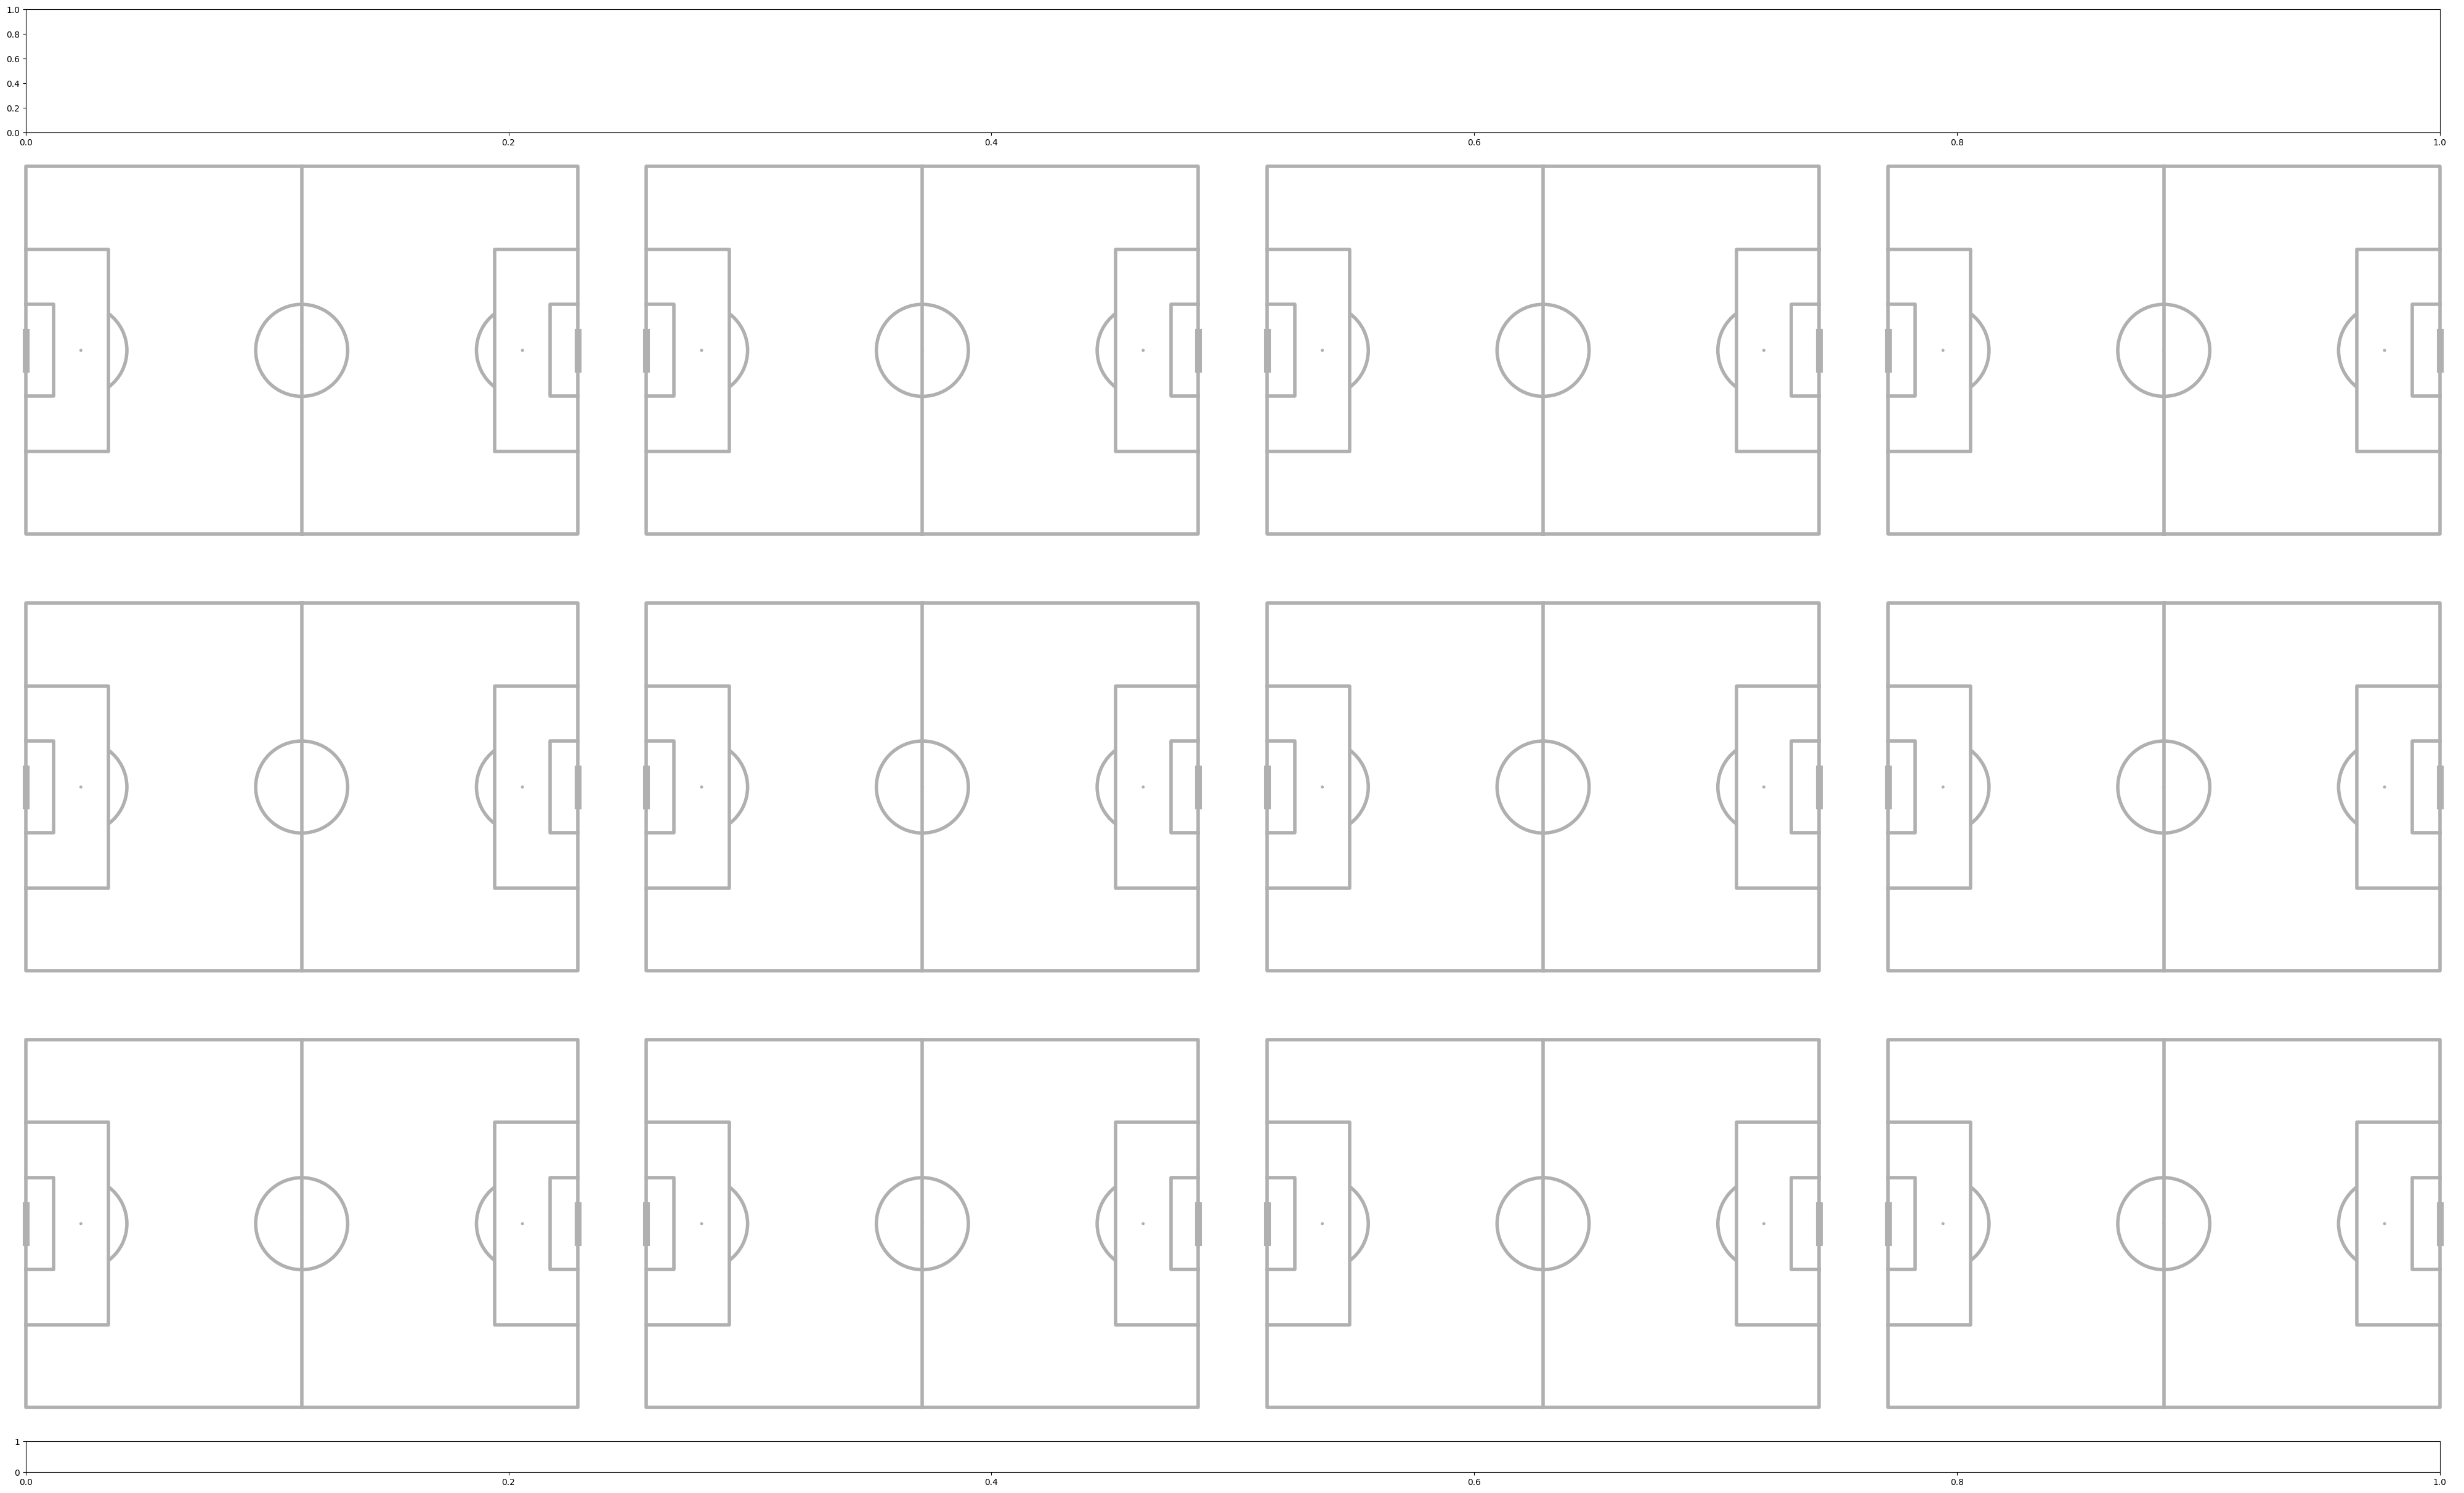

In [4]:
pitch = Pitch(linewidth=4)
fig, axs = pitch.grid(nrows=3, ncols=4,  # number of rows/ columns
                      figheight=25,  # the figure height in inches
                      bottom=0.025,  # starts 2.5% in from the figure bottom
                      # grid takes up 83% of the figure height
                      # I calculated this so most of the figure is pitches
                      # 1 - (bottom + endnote_height + endnote_space +
                      # title_height + title_space) - 0.025 [space at top]
                      grid_height=0.83,
                      # reduced the amount of the figure height reserved
                      # for the ax_endnote and ax_title since it is in
                      # fractions of the figure height and the figure height
                      # has increased. e.g. now the title_height is
                      # 8% of the figheight (25).
                      grid_width=0.95,  # the grid takes up 95% of the figwidth
                      # 5% of the grid_height is the space between pitches.
                      space=0.05,
                      endnote_height=0.02, endnote_space=0.01,
                      title_height=0.08, title_space=0.01)

## Removing the endnote/title
You can remove the endnote/title axis by setting the endnote_height/ title_height
to zero.



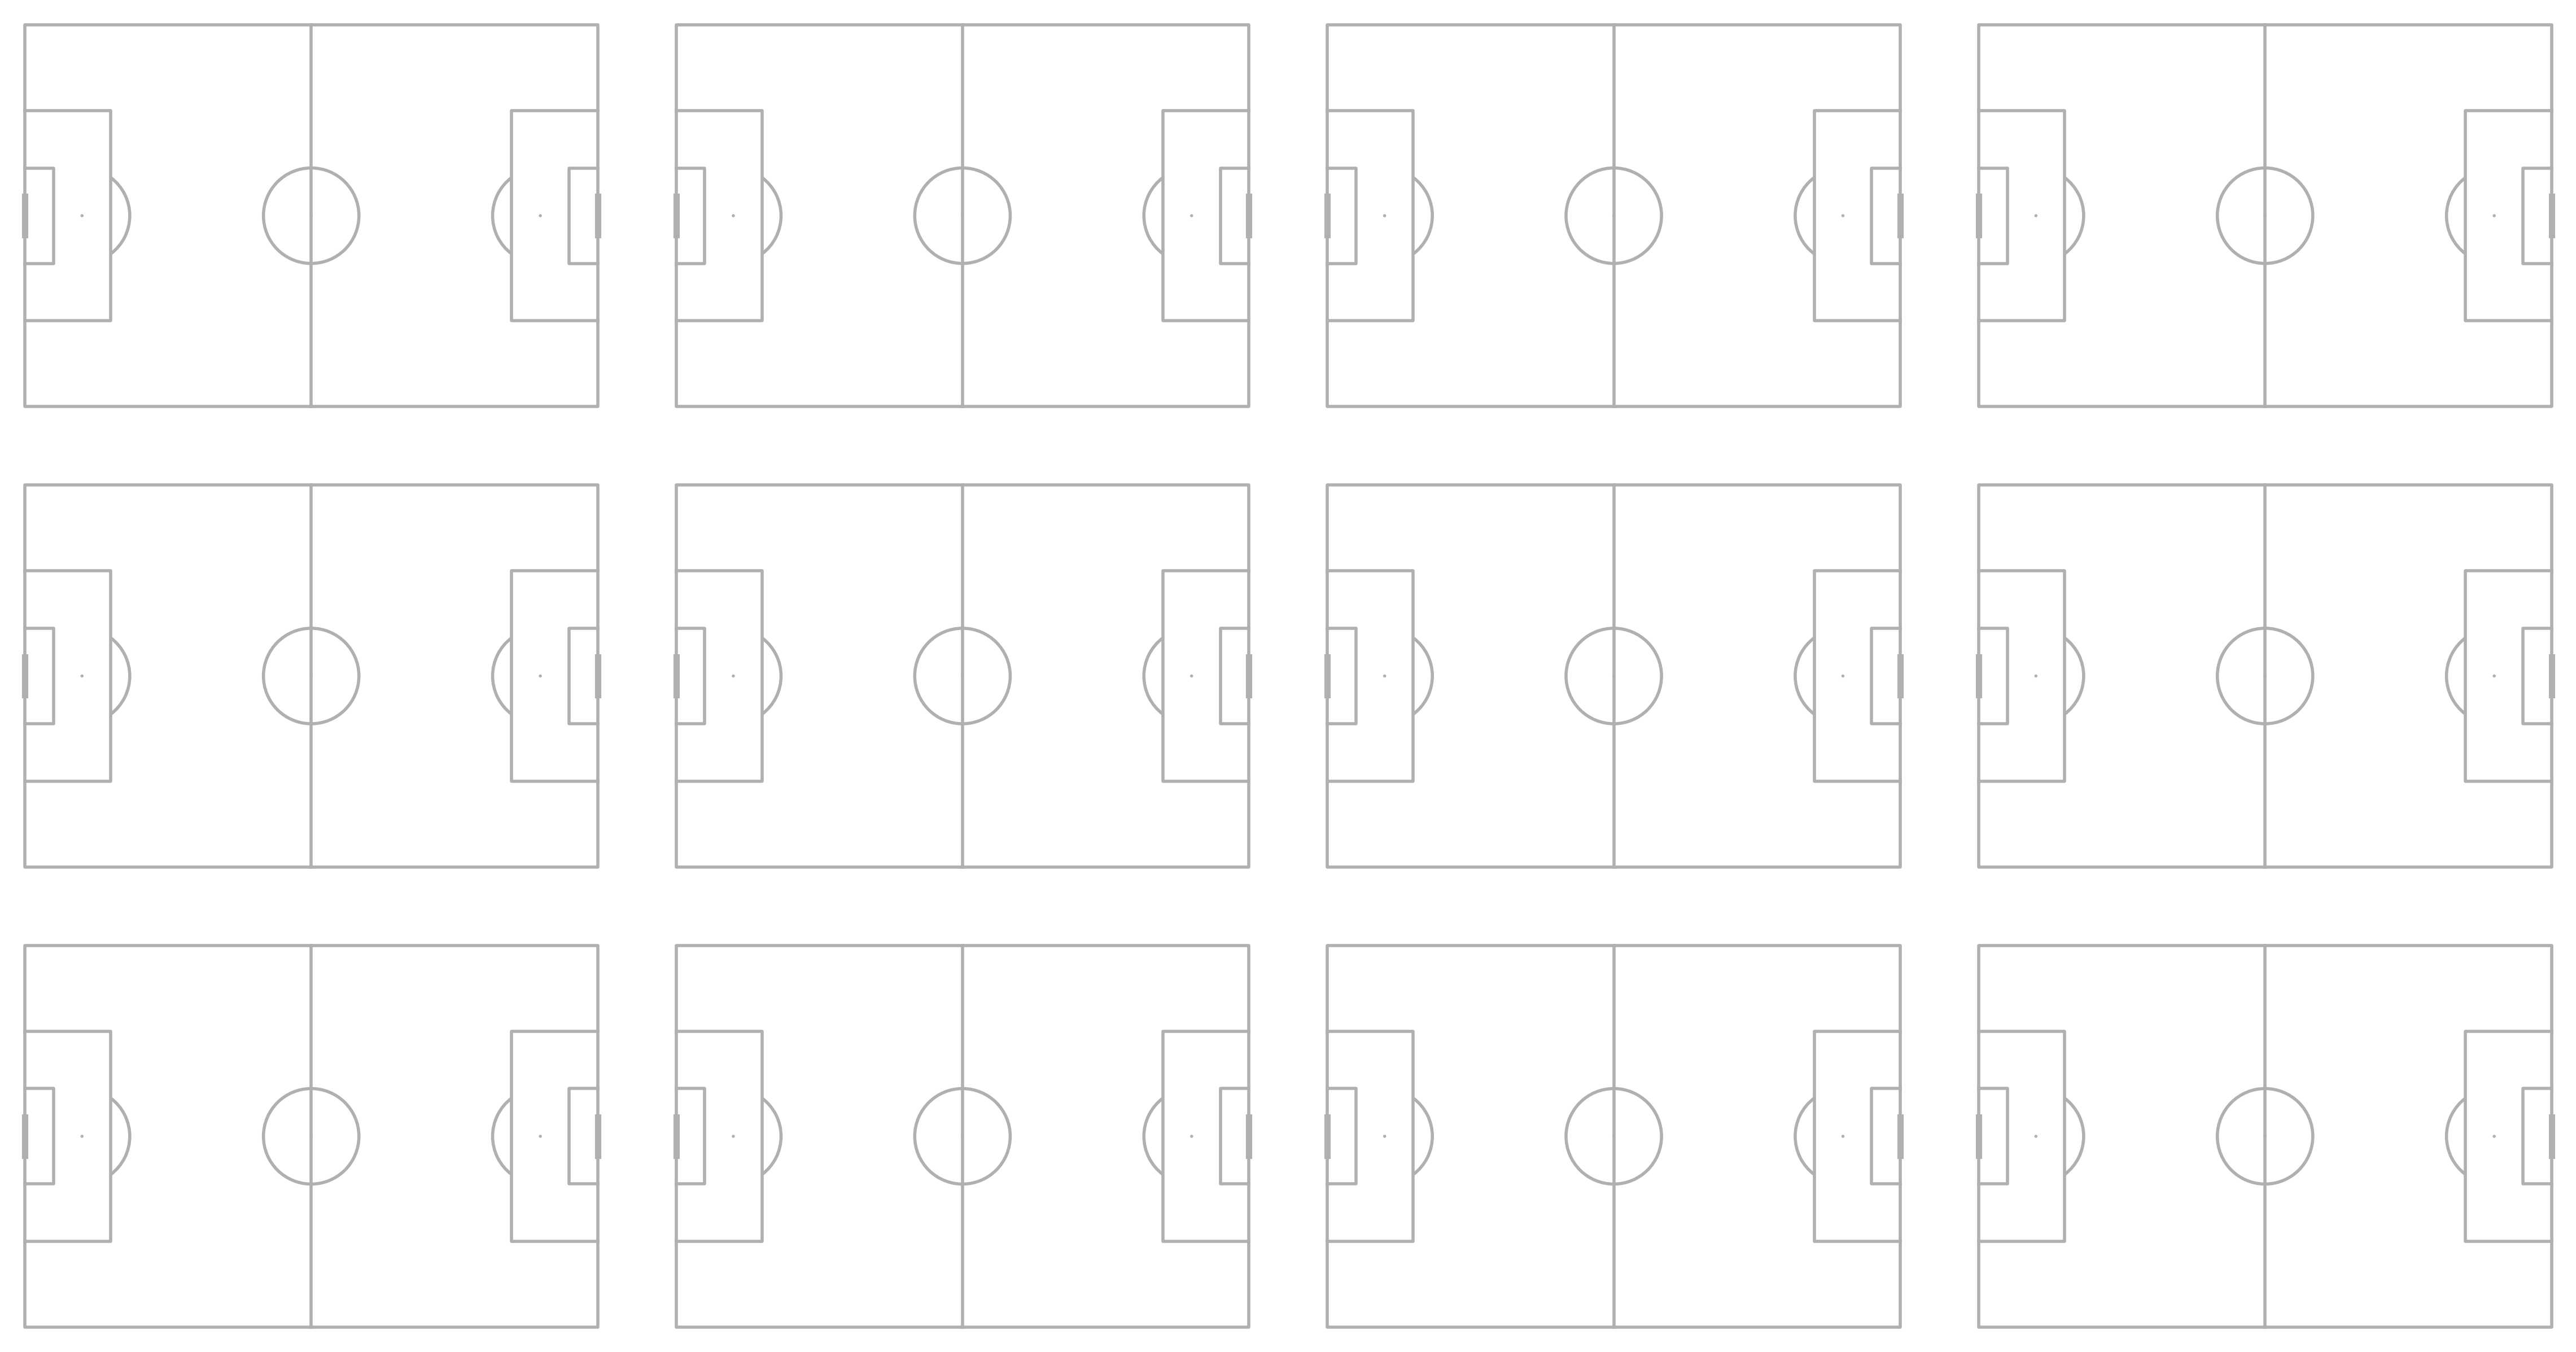

In [5]:
pitch = Pitch(linewidth=4)
fig, axs = pitch.grid(nrows=3, ncols=4,  # number of rows/ columns
                      figheight=25,  # the figure height in inches
                      bottom=0.025,  # starts 2.5% in from the figure bottom
                      # increased the grid_height as no title/ endnote
                      # now it takes up 95% of the figheight
                      grid_height=0.95,
                      grid_width=0.95,  # the grid takes up 95% of the figwidth
                      # 6% of the grid_height is the space between pitches.
                      space=0.06,
                      # set the endnote/title height to zero so
                      # they are not plotted. note this automatically
                      # sets the endnote/title space to zero
                      # so the grid starts at the bottom/left location
                      endnote_height=0, title_height=0)

## Pass maps
The following example plots pass maps for each player on a team.
The plot design is copied from
[Brad (@DymondFormation)](https://twitter.com/DymondFormation).

First we need to get the StatsBomb events, tactics, and lineup data



In [6]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(15946)
lineup = parser.lineup(15946)

Add on the subbed on/ off times to the lineup dataframe



In [7]:
# dataframe with player_id and when they were subbed off
time_off = events.loc[(events.type_name == 'Substitution'),
                      ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)
# dataframe with player_id and when they were subbed on
time_on = events.loc[(events.type_name == 'Substitution'),
                     ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id',
                'minute': 'on'}, axis='columns', inplace=True)
players_on = time_on.player_id
# merge on times subbed on/off
lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

Filter the lineup to include players who played and add on the first position they played



In [8]:
# filter the tactics lineup for the starting xi
starting_ids = events[events.type_name == 'Starting XI'].id
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

# filter the lineup for players that actually played
mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) |
               (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

# get the first position for each player and add this to the lineup dataframe
player_positions = (events[['player_id', 'position_id']]
                    .dropna(how='any', axis='rows')
                    .drop_duplicates('player_id', keep='first'))
lineup = lineup.merge(player_positions, how='left', on='player_id')

# add on the position abbreviation
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

# sort the dataframe so the players are
# in the order of their position (if started), otherwise in the order they came on
lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],
                   ascending=[True, False, True, True], inplace=True)

Filter the lineup/ events to one team and exclude some set pieces



In [9]:
# filter the lineup for Barcelona players
# if you want the other team set team = team2
team1, team2 = lineup.team_name.unique()  # Barcelona (team1), Deportivo Alavés (team2)
team = team1
lineup_team = lineup[lineup.team_name == team].copy()

# filter the events to exclude some set pieces
set_pieces = ['Throw-in', 'Free Kick', 'Corner', 'Kick Off', 'Goal Kick']
# for the team pass map
pass_receipts = events[(events.team_name == team) & (events.type_name == 'Ball Receipt')].copy()
# for the player pass maps
passes_excl_throw = events[(events.team_name == team) & (events.type_name == 'Pass') &
                           (events.sub_type_name != 'Throw-in')].copy()

# identify how many players played and how many subs were used
# we will use this in the loop for only plotting pass maps for as
# many players who played
num_players = len(lineup_team)
num_sub = num_players - 11

Setup the pitch, arrows, and get some images



In [10]:
# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
                       'Scada-Regular.ttf')

# Load the Club/ Statsbomb logos
# these are the property of the respective clubs/ StatsBomb.
BARCA_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/4/47/'
                  'FC_Barcelona_%28crest%29.svg/142px-FC_Barcelona_%28crest%29.svg.png')
DEPORTIVO_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/f/f8/'
                      'Deportivo_Alaves_logo_%282020%29.svg/'
                      '300px-Deportivo_Alaves_logo_%282020%29.svg.png')
SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
               'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
barca_logo = Image.open(urlopen(BARCA_LOGO_URL))
deportivo_logo = Image.open(urlopen(DEPORTIVO_LOGO_URL))
sb_logo = Image.open(urlopen(SB_LOGO_URL))

Plotting the Pass Maps



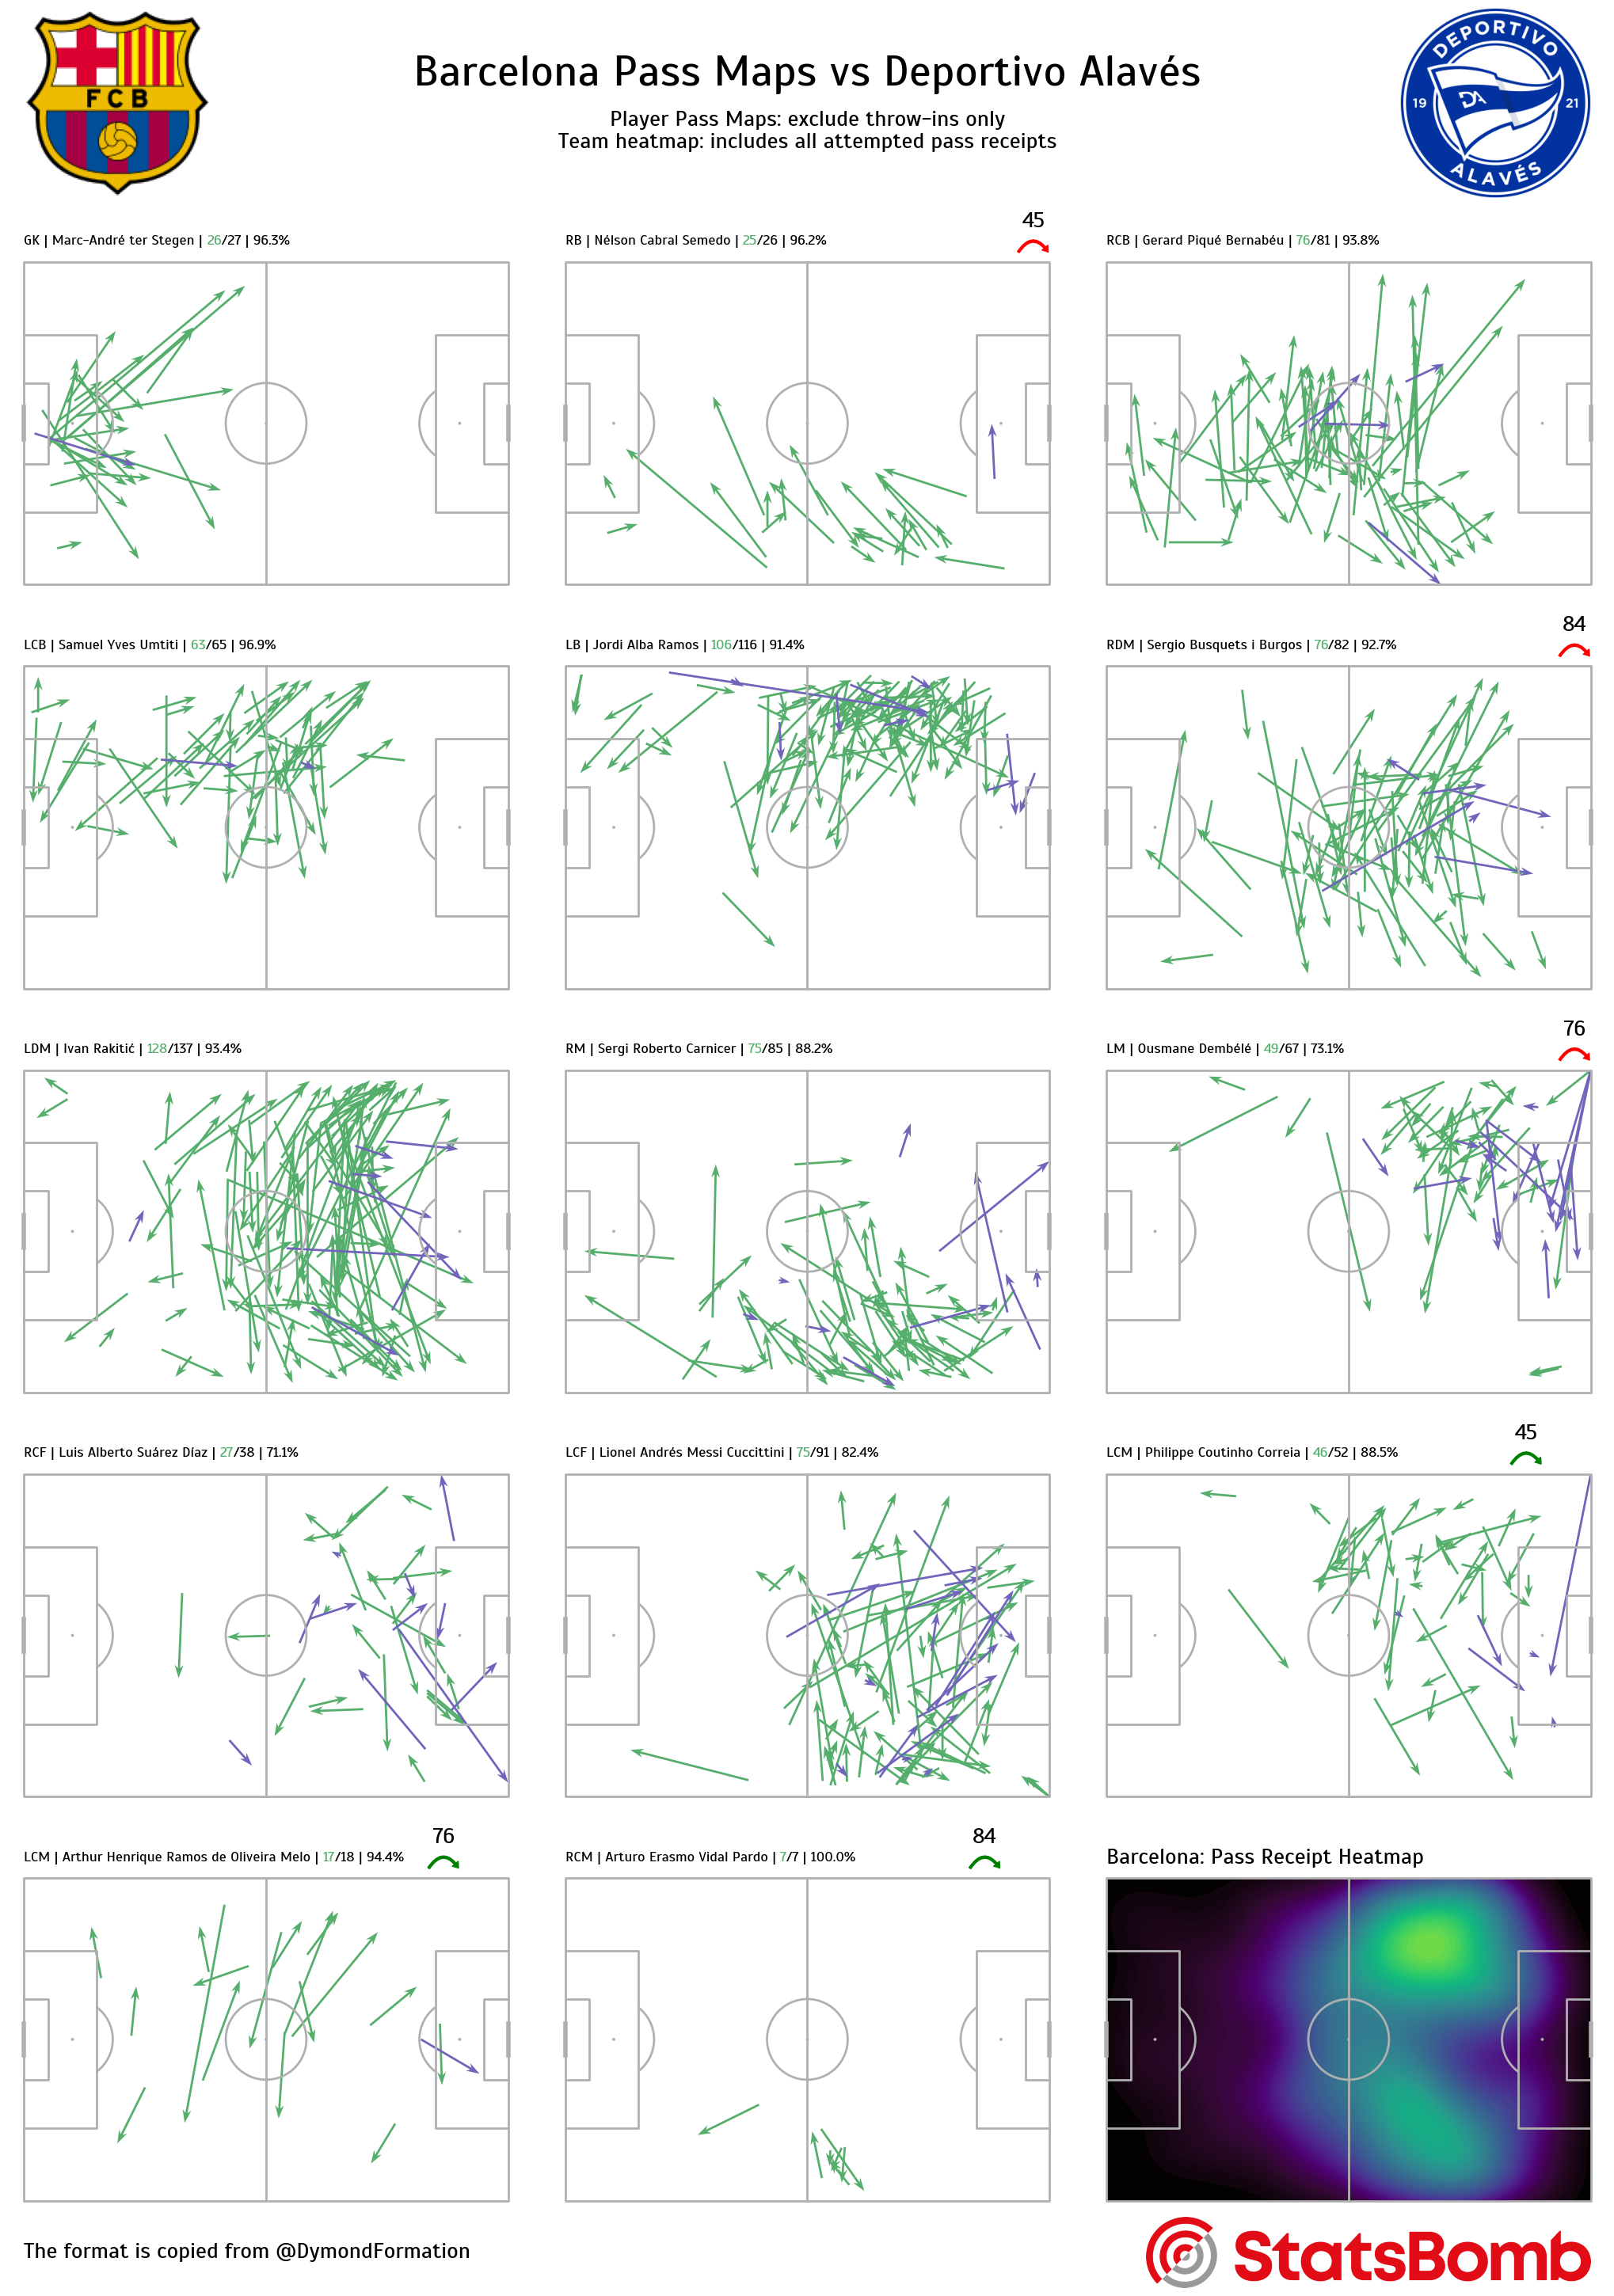

In [11]:
# filtering out some highlight_text warnings - the warnings aren't correct as the
# text fits inside the axes.
warnings.simplefilter("ignore", UserWarning)

# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=5, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    # only plot the pass maps up to the total number of players
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)

        # plot the title for each player axis
        # here we use f-strings to combine the variables from the dataframe and text
        # we plot the title at x=0, y=-5
        # this is the left hand-side of the pitch (x=0) and between
        # top of the y-axis (y=0) and the top of the padding (y=-10, remember pad_top = 10)
        # note that the StatsBomb y-axis is inverted, so you may need
        # to change this if you use another pitch_type (e.g. 'uefa').
        # We also use the highlight-text package to highlight complete_pass green
        # so put <> around the number of completed passes.
        total_pass = len(complete_pass) + len(incomplete_pass)
        annotation_string = (f'{lineup_player.position_abbreviation} | '
                             f'{lineup_player.player_name} | '
                             f'<{len(complete_pass)}>/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)

# plot on the last Pass Map
# (note ax=ax as we have cycled through to the last axes in the loop)
pitch.kdeplot(x=pass_receipts.x, y=pass_receipts.y, ax=ax,
              cmap=cmr.lavender,
              levels=100,
              thresh=0, fill=True)
ax.text(0, -5, f'{team}: Pass Receipt Heatmap', ha='left', va='center',
        fontsize=20, fontproperties=fm_scada.prop)

# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:-1]:
    ax.remove()

# endnote text
axs['endnote'].text(0, 0.5, 'The format is copied from @DymondFormation',
                    fontsize=20, fontproperties=fm_scada.prop, va='center', ha='left')
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_sb = ax_sb_logo.get_position()
# bbox_endnote = axs['endnote'].get_position()
# left = bbox_endnote.x1 - bbox_sb.width
ax_sb_logo = add_image(sb_logo, fig, left=0.701126,
                       # set the bottom and height to align with the endnote
                       bottom=axs['endnote'].get_position().y0,
                       height=axs['endnote'].get_position().height)

# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center')
# plot logos (same height as the title_ax)
# set the barca logo to align with the left/bottom of the title axes
ax_barca_logo = add_image(barca_logo, fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
# set the deportivo logo to align with the right/bottom of the title axes
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_logo = ax_deportivo_logo.get_position()
# bbox_title = axs['title'].get_position()
# left = bbox_title.x1 - bbox_logo.width
ax_deportivo_logo = add_image(deportivo_logo, fig, left=0.8521,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)
# setting this example to the gallery thumbnail
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_grid_005'

plt.show()  # If you are using a Jupyter notebook you do not need this line